In [81]:
from scipy.sparse import csc_matrix
from scipy.io import mmread
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

In [82]:
matrix_geneData = mmread('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/DATA/Taylor_etal_scRNA/GSE136049_gene_by_barcode_count_matrix_all_cells.mtx')
#Convert the matrix to a compressed sparse column (CSC) matrix format in order to do indexing operations
matrix_geneData_csc = csc_matrix(matrix_geneData)
geneKey = pd.read_csv('/Users/cmdb/Desktop/GORDUS_rotation/ASJ_neuron_stuff/DATA/Taylor_etal_scRNA/GSE136049_cell_type_annotation_lookup_table.csv')


#list of ALL cell barcodes
barcode_list = geneKey['barcode'].tolist()
#Creating a dictionary mapping each barcode to its index (row #)
bracodeIndex = {barcode: index for index, barcode in enumerate(barcode_list)}


#filtering out only ASJ cells (they aren't specified as left or right... that is what we are trying to visualize!)
ASJ_cells_key = geneKey[geneKey['cell.type'] == 'ASJ'] 
#list of ASJ cell barcodes
ASJ_cell_ids = ASJ_cells_key['barcode'].tolist()
#Get the indices of ASJ cells in the barcode list
ASJ_cell_indices = [bracodeIndex[barcode] for barcode in ASJ_cell_ids] 


#Extract the gene expression data for ASJ cells from sparse matrix
ASJ_geneData = matrix_geneData_csc[:, ASJ_cell_indices] #this is assuming that the order of genes (barcodes) are the same for the rows in geneKey and the columns in the matrix_geneData
# print(ASJ_geneData)

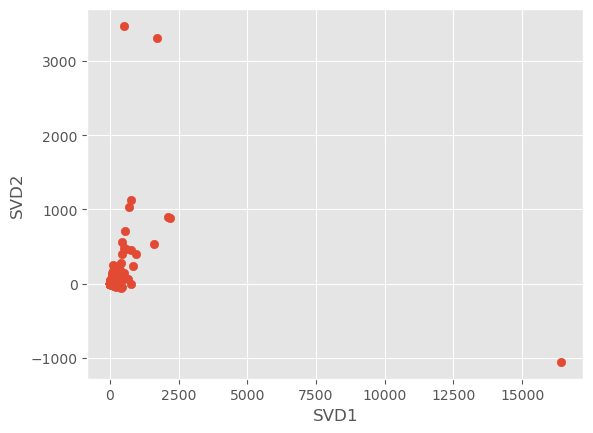

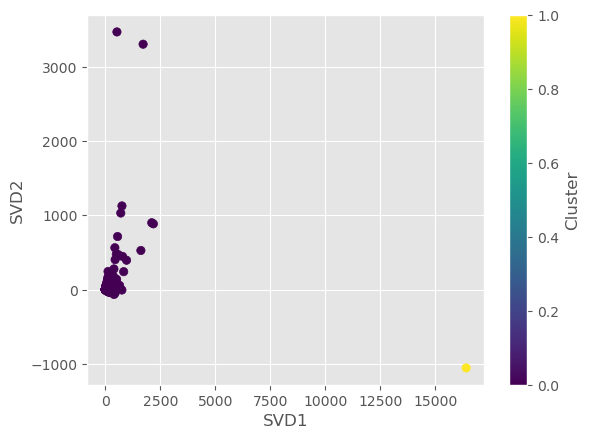

In [83]:
#performing dimensionality reduction with the sparse matrix
svd = TruncatedSVD(n_components=2)
svd_result = svd.fit_transform(ASJ_geneData)

plt.style.use("ggplot") #to have plot look more like ggplot2 in R
plt.scatter(svd_result[:,0], svd_result[:,1],)
plt.xlabel("SVD1")
plt.ylabel("SVD2")
plt.show()



kmeans = KMeans(n_clusters=2, random_state=0).fit(ASJ_geneData)

clusters = kmeans.labels_

plt.scatter(svd_result[:,0], svd_result[:,1], c=clusters, cmap='viridis')
plt.xlabel("SVD1")
plt.ylabel("SVD2")
plt.colorbar(label='Cluster')
plt.show()


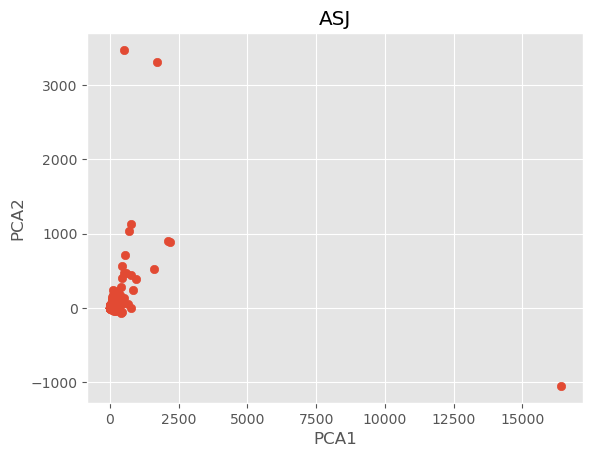

In [84]:
#converting the sparse matrix to a dense matrix
ASJ_geneData_dense = ASJ_geneData.toarray()

pca2 = PCA(n_components=2)
pca_result_ASJ2 = pca2.fit_transform(ASJ_geneData_dense)

plt.style.use("ggplot")
plt.title("ASJ")
plt.scatter(pca_result_ASJ2[:,0], pca_result_ASJ2[:,1])
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

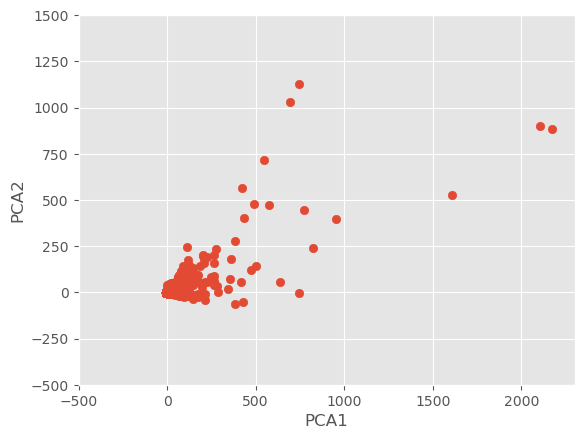

In [85]:
#re-plot removing "outliers"
pca2 = PCA(n_components=2)
pca_result_ASJ2_noOutlier = pca2.fit_transform(ASJ_geneData_dense)

plt.style.use("ggplot")
plt.scatter(pca_result_ASJ2_noOutlier[:,0], pca_result_ASJ2_noOutlier[:,1])
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.xlim(-500,2300)
plt.ylim(-500,1500)
plt.show()

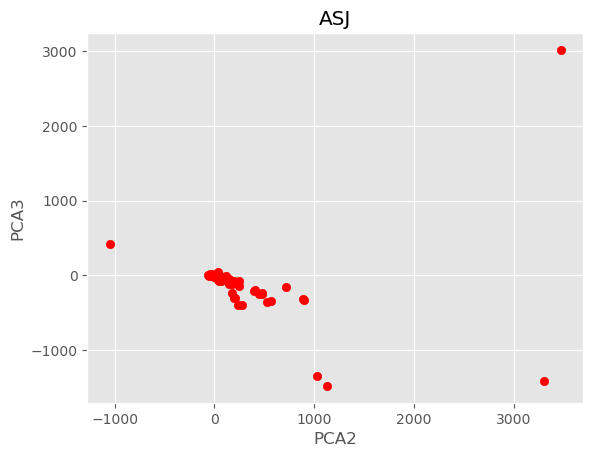

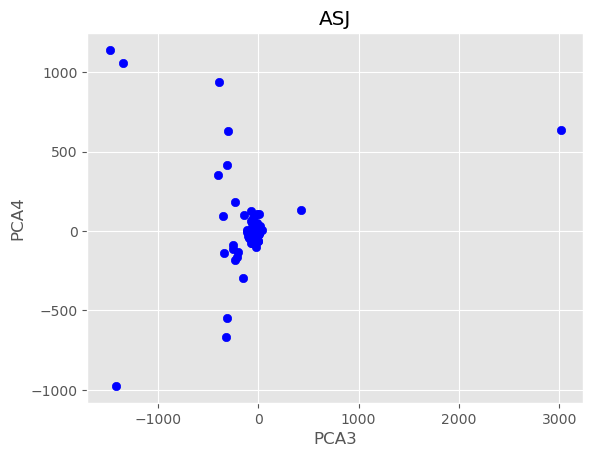

In [86]:
# plotting components 2 and 3 instead of 1 and 2
pca3 = PCA(n_components=3)
pca_result_ASJ3 = pca3.fit_transform(ASJ_geneData_dense)

plt.style.use("ggplot")
plt.title("ASJ")
plt.scatter(pca_result_ASJ3[:,1], pca_result_ASJ3[:,2], color = 'red')
plt.xlabel("PCA2")
plt.ylabel("PCA3")
plt.show()

pca4 = PCA(n_components=4)
pca_result_ASJ4 = pca4.fit_transform(ASJ_geneData_dense)

plt.style.use("ggplot")
plt.title("ASJ")
plt.scatter(pca_result_ASJ4[:,2], pca_result_ASJ4[:,3], color = 'blue')
plt.xlabel("PCA3")
plt.ylabel("PCA4")
plt.show()

In [87]:
#Isolating AVA cell data too, and then plotting PCA 
AVA_cells_key = geneKey[geneKey['cell.type'] == 'AVA'] 
#list of ASJ cell barcodes
AVA_cell_ids = AVA_cells_key['barcode'].tolist()
#Get the indices of AVA cells in the barcode list
AVA_cell_indices = [bracodeIndex[barcode] for barcode in AVA_cell_ids] 

#Extract the gene expression data for AVA cells from sparse matrix
AVA_geneData = matrix_geneData_csc[:, AVA_cell_indices]

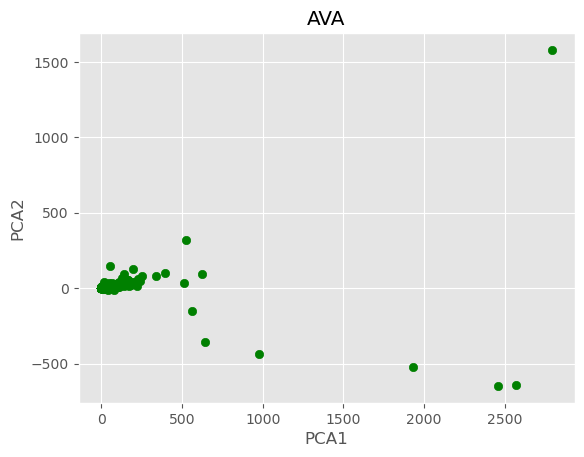

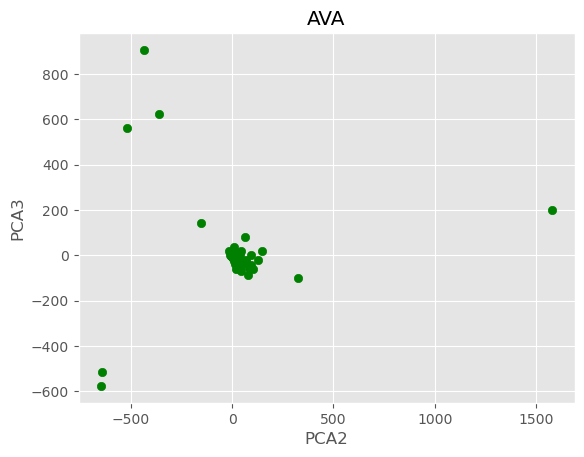

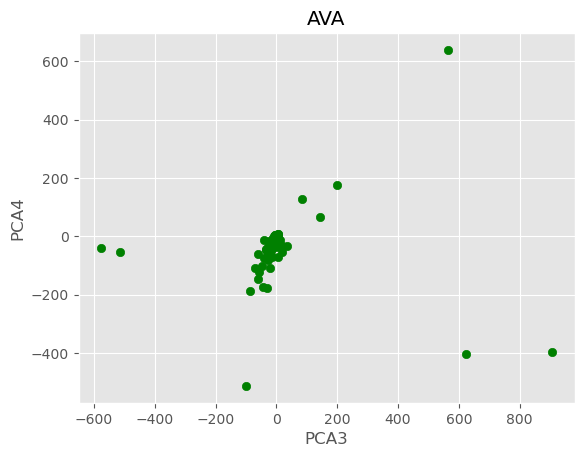

In [88]:
#converting the sparse matrix to a dense matrix
AVA_geneData_dense = AVA_geneData.toarray()

pca2 = PCA(n_components=2)
pca_result_AVA2 = pca2.fit_transform(AVA_geneData_dense)

plt.style.use("ggplot")
plt.title("AVA")
plt.scatter(pca_result_AVA2[:,0], pca_result_AVA2[:,1], color = 'green')
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

pca3 = PCA(n_components=3)
pca_result_AVA3 = pca3.fit_transform(AVA_geneData_dense)

plt.style.use("ggplot")
plt.title("AVA")
plt.scatter(pca_result_AVA3[:,1], pca_result_AVA3[:,2], color = 'green')
plt.xlabel("PCA2")
plt.ylabel("PCA3")
plt.show()

pca4 = PCA(n_components=4)
pca_result_AVA4 = pca4.fit_transform(AVA_geneData_dense)
plt.title("AVA")

plt.style.use("ggplot")
plt.scatter(pca_result_AVA4[:,2], pca_result_AVA4[:,3], color = 'green')
plt.xlabel("PCA3")
plt.ylabel("PCA4")
plt.show()

In [89]:
#Isolating AWA cell data too, and then plotting PCA 
AWA_cells_key = geneKey[geneKey['cell.type'] == 'AWA'] 
#list of ASJ cell barcodes
AWA_cell_ids = AWA_cells_key['barcode'].tolist()
#Get the indices of AWA cells in the barcode list
AWA_cell_indices = [bracodeIndex[barcode] for barcode in AWA_cell_ids] 

#Extract the gene expression data for AWA cells from sparse matrix
AWA_geneData = matrix_geneData_csc[:, AWA_cell_indices]

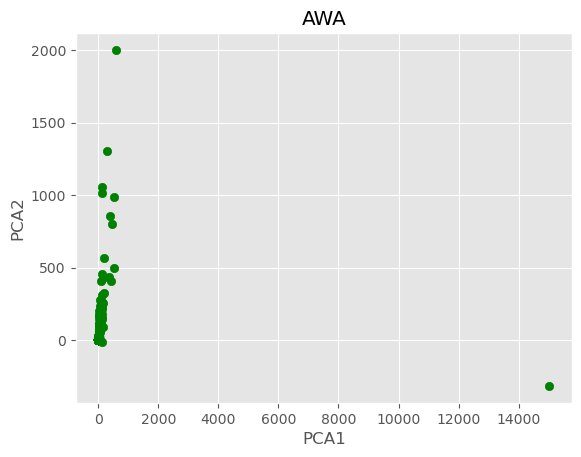

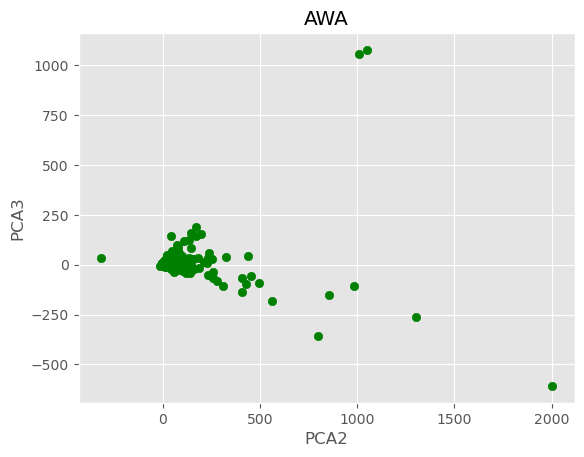

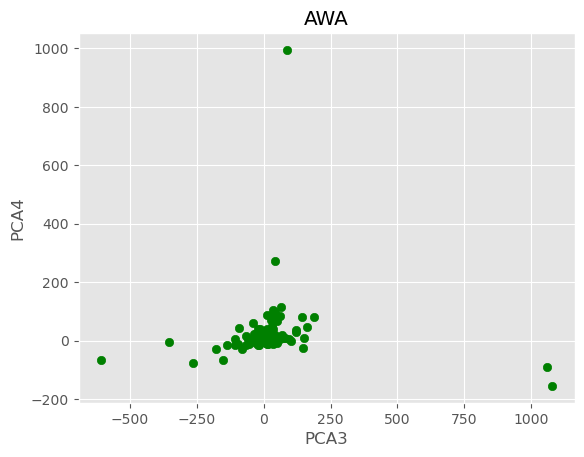

In [90]:
AWA_geneData_dense = AWA_geneData.toarray()

pca2 = PCA(n_components=2)
pca_result_AWA_2 = pca2.fit_transform(AWA_geneData_dense)

plt.style.use("ggplot")
plt.title("AWA")
plt.scatter(pca_result_AWA_2[:,0], pca_result_AWA_2[:,1], color = 'purple')
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

pca3 = PCA(n_components=3)
pca_result_AWA_3 = pca3.fit_transform(AWA_geneData_dense)

plt.style.use("ggplot")
plt.title("AWA")
plt.scatter(pca_result_AWA_3[:,1], pca_result_AWA_3[:,2], color = 'purple')
plt.xlabel("PCA2")
plt.ylabel("PCA3")
plt.show()

pca4 = PCA(n_components=4)
pca_result_AWA_4 = pca4.fit_transform(AWA_geneData_dense)
plt.title("AWA")

plt.style.use("ggplot")
plt.scatter(pca_result_AWA_4[:,2], pca_result_AWA_4[:,3], color = 'purple')
plt.xlabel("PCA3")
plt.ylabel("PCA4")
plt.show()

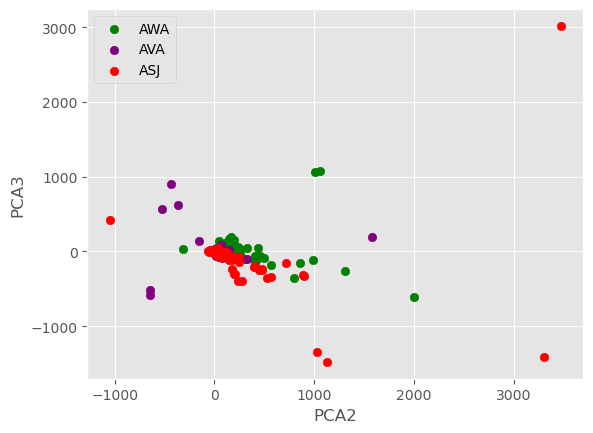

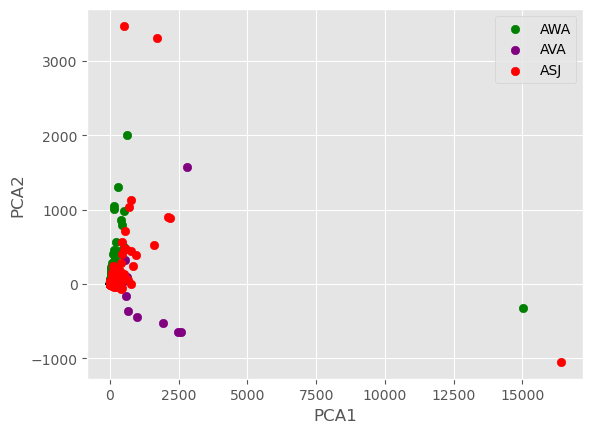

In [96]:
pca3 = PCA(n_components=3)
pca_result_AWA = pca3.fit_transform(AWA_geneData_dense)

plt.style.use("ggplot")
plt.scatter(pca_result_AWA[:,1], pca_result_AWA[:,2], color = 'green', label = "AWA")
plt.xlabel("PCA2")
plt.ylabel("PCA3")
plt.legend()

pca_result_AVA = pca3.fit_transform(AVA_geneData_dense)

plt.style.use("ggplot")
plt.scatter(pca_result_AVA[:,1], pca_result_AVA[:,2], color = 'purple', label = "AVA")
plt.xlabel("PCA2")
plt.ylabel("PCA3")
plt.legend()

pca_result_ASJ = pca3.fit_transform(ASJ_geneData_dense)

plt.style.use("ggplot")
plt.scatter(pca_result_ASJ[:,1], pca_result_ASJ[:,2], color = 'red', label = 'ASJ')
plt.xlabel("PCA2")
plt.ylabel("PCA3")
plt.legend()
plt.show()


pca2 = PCA(n_components=2)
pca_result_AWA_2 = pca2.fit_transform(AWA_geneData_dense)

plt.style.use("ggplot")
plt.scatter(pca_result_AWA_2[:,0], pca_result_AWA_2[:,1], color = 'green', label = "AWA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()

pca_result_AVA_2 = pca2.fit_transform(AVA_geneData_dense)

plt.style.use("ggplot")
plt.scatter(pca_result_AVA_2[:,0], pca_result_AVA_2[:,1], color = 'purple', label = "AVA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()

pca_result_ASJ_2 = pca2.fit_transform(ASJ_geneData_dense)

plt.style.use("ggplot")
plt.scatter(pca_result_ASJ_2[:,0], pca_result_ASJ_2[:,1], color = 'red', label = 'ASJ')
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()
